In [8]:
pip install biosignalsnotebooks


Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pywavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB 653.6 kB/s eta 0:00:07
   - -------------------------------------- 0.1/4.2 MB 1.2 MB/s eta 0:00:04
   ---- ----------------------------------- 0.5/4.2 MB 3.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.7/4.2 MB 4.2 MB/s eta 0:00:01
   ---------- ----------------------------- 1.1/4.2 MB 4.8 MB/s eta 0:00:01
   --------------- ------------------------ 1.6/4.2 MB 5.6 MB/s eta 0:00:01
   ------------------ --------------------- 2.0/4.2 MB 6.0 MB/s eta 0:00:01
   ------------------------ --------------- 2.5/4.2 MB 6.5 MB/s eta 0:00:01
   --------------------------- ------------ 2.9/4.2 MB 6.6 MB/s eta 0:00:01
   -------------------------------- ------- 3.4/4.2 MB 6.9 MB/s eta 0:00:01
   ----------------------------------- ---- 3.7/4.2 MB 6.9 MB/s eta 0:00:01
   ---------------------

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Cargar data cruda
EMG_data = np.loadtxt('pulgar_flexion.txt')
columna_EMG = EMG_data[:, -1]
# Convertir los valores de la señal de 0-1023 a 0-3.3V
signal_EMG = ((columna_EMG - 507) / 1023) * 3.3 * 1000
# Frecuencia de muestreo del BiTalino: 1000 Hz
fs = 1000
N = len(signal_EMG)
# Crear el eje de tiempo
t = np.linspace(0, N/fs, N)

def Wavelet_filter_1(signal):  # Sym8
    wavelet = 'sym8'
    niveles = 9
    coeffs = pywt.wavedec(signal, wavelet, level=niveles)
    # Eliminar coeficientes específicos D1, D8, D9 y A9, según lo realizado en el Paper
    coeffs[0] = np.zeros_like(coeffs[0])  # A9
    coeffs[1] = np.zeros_like(coeffs[1])  # D9
    coeffs[2] = np.zeros_like(coeffs[2])  # D8
    coeffs[-1] = np.zeros_like(coeffs[-1])  # D1

    # Reconstrucción de la señal filtrada
    denoised_signal = pywt.waverec(coeffs, wavelet)
    return denoised_signal

def Wavelet_filter_2(signal):  # Db4
    wavelet = 'db4'
    niveles = 4
    coeffs = pywt.wavedec(signal, wavelet, level=niveles)
    # Hallar el Universal Threshold
    detail_coeffs = coeffs[-1]
    sigma = np.median(np.abs(detail_coeffs)) / 0.6745
    n = len(signal)
    threshold = sigma * np.sqrt(2 * np.log(n))
    # Aplicar el Threshold (soft) a los coeficientes
    new_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    # Reconstrucción de la señal filtrada
    denoised_signal = pywt.waverec(new_coeffs, wavelet)
    return denoised_signal

def Wavelet_filter_3(signal):  # Rbio3.1
    wavelet = 'rbio3.1'
    niveles = 7
    coeffs = pywt.wavedec(signal, wavelet, level=niveles)
    # Eliminar coeficientes específicos D1, D6, D7 y A7, según lo realizado en el Paper
    coeffs[0] = np.zeros_like(coeffs[0])  # A7
    coeffs[1] = np.zeros_like(coeffs[1])  # D7
    coeffs[2] = np.zeros_like(coeffs[2])  # D6
    coeffs[3] = np.zeros_like(coeffs[3])  # D5
    # Reconstrucción de la señal filtrada
    denoised_signal = pywt.waverec(coeffs, wavelet)
    return denoised_signal

def calculate_snr(original_signal, filtered_signal):
    # Calcular el ruido
    noise = original_signal - filtered_signal
    # Potencia de la señal original
    signal_power = np.mean(original_signal ** 2)
    # Potencia del ruido
    noise_power = np.mean(noise ** 2)
    # Calcular SNR
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rms(original_signal, filtered_signal):
    signal = original_signal - filtered_signal
    rms = np.sqrt(np.mean(np.square(signal)))
    return rms

def MSE(original_signal, filtered_signal):
    mse = np.mean((original_signal - filtered_signal) ** 2)
    return mse

# FILTRO 1 = sym8
filtered_1 = Wavelet_filter_1(signal_EMG)
# FILTRO 2 = dB4
filtered_2 = Wavelet_filter_2(signal_EMG)
# FILTRO 3 = Rbio3.1
filtered_3 = Wavelet_filter_3(signal_EMG)

# Calcular SNR para cada filtro
snr_sym8 = calculate_snr(signal_EMG, filtered_1)
snr_db4 = calculate_snr(signal_EMG, filtered_2)
snr_rbio3_1 = calculate_snr(signal_EMG, filtered_3)

# Mostrar resultados de SNR
print(f"SNR Sym8: {snr_sym8:.2f} dB")
print(f"SNR Db4: {snr_db4:.2f} dB")
print(f"SNR Rbio3.1: {snr_rbio3_1:.2f} dB\n")

# Calcular el Error Cuadrático Medio (MSE)
mse_sym8 = MSE(signal_EMG, filtered_1)
mse_db4 = MSE(signal_EMG, filtered_2)
mse_rbio3_1 = MSE(signal_EMG, filtered_3)

# Mostrar resultados de MSE
print(f"MSE Sym8: {mse_sym8:.2f}")
print(f"MSE Db4: {mse_db4:.2f}")
print(f"MSE Rbio3.1: {mse_rbio3_1:.2f}\n")

rms_sym8 = calculate_rms(signal_EMG, filtered_1)
rms_db4 = calculate_rms(signal_EMG, filtered_2)
rms_rbio3_1 = calculate_rms(signal_EMG, filtered_3)

# Mostrar resultados de RMS
print(f"RMS Sym8: {rms_sym8:.4f}")
print(f"RMS DB4: {rms_db4:.4f}")
print(f"RMS Rbio3.1: {rms_rbio3_1:.4f}")

SNR Sym8: 17.15 dB
SNR Db4: 14.45 dB
SNR Rbio3.1: 4.75 dB

MSE Sym8: 127.14
MSE Db4: 236.92
MSE Rbio3.1: 2211.81

RMS Sym8: 11.2756
RMS DB4: 15.3922
RMS Rbio3.1: 47.0299


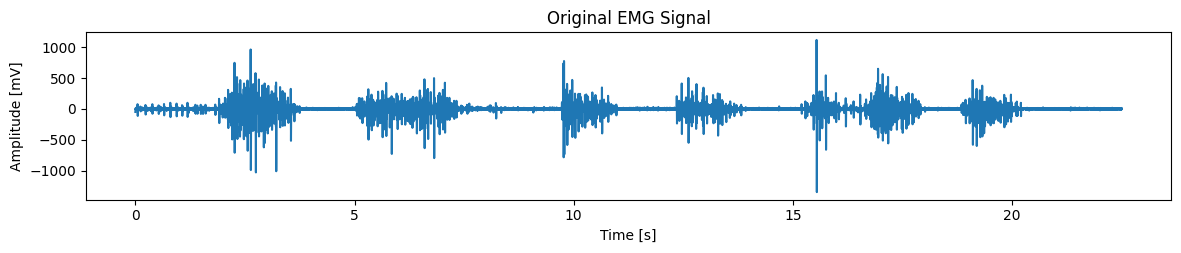

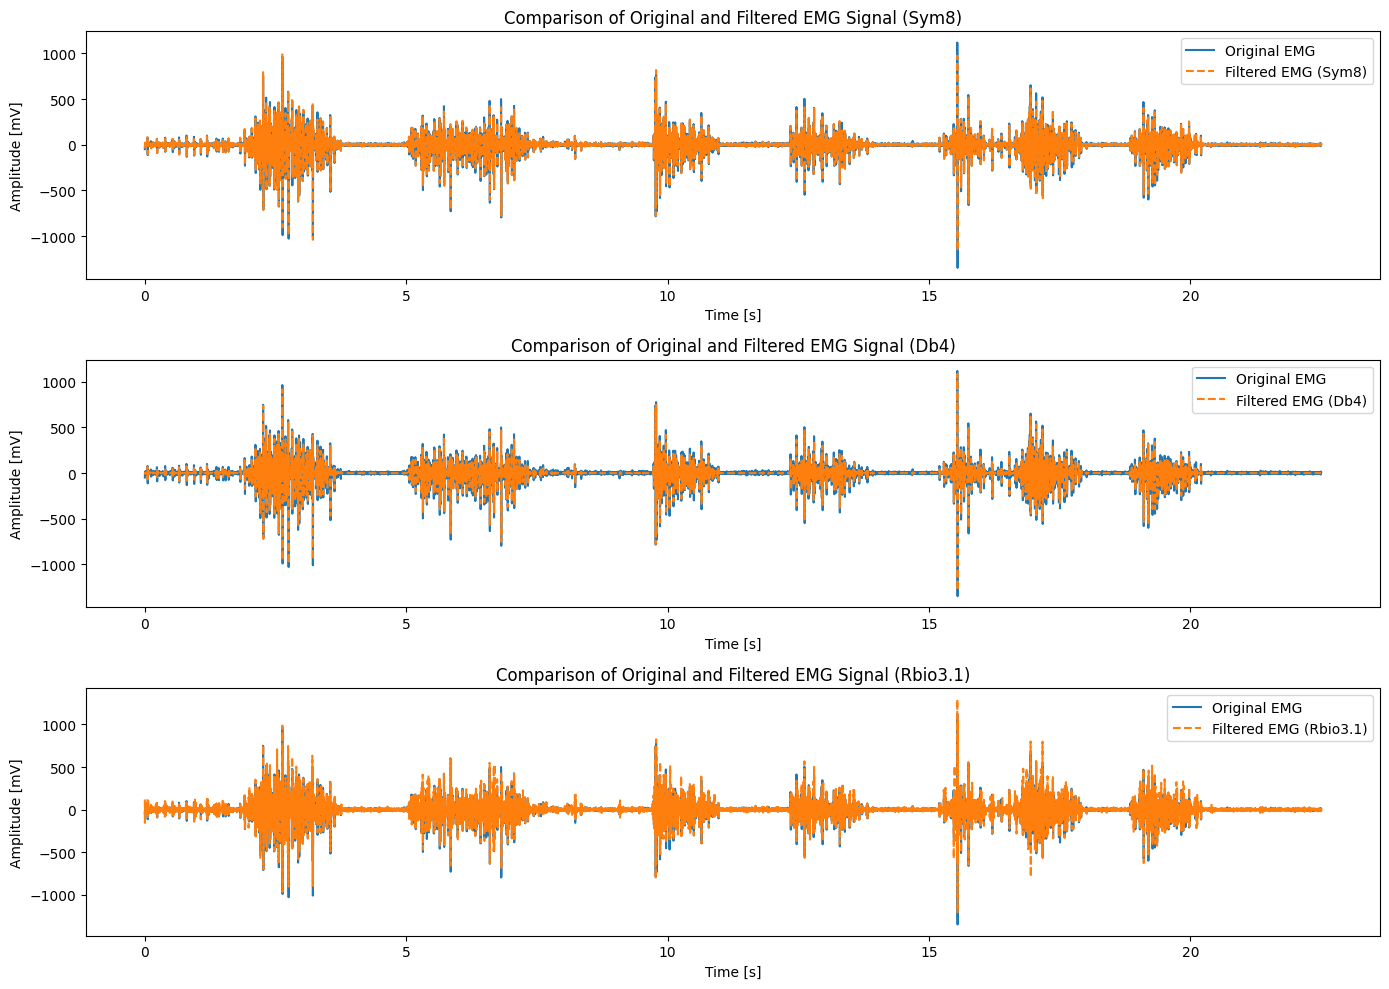

In [14]:
# Plot de las señales originales y filtradas
plt.figure(figsize=(14, 10))

# Señal original
plt.subplot(4, 1, 1)
plt.plot(t, signal_EMG, label='Original EMG')
plt.title('Original EMG Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')

# Comparación de las señales originales y filtradas
plt.figure(figsize=(14, 10))

# Señal original y filtrada con Sym8
plt.subplot(3, 1, 1)
plt.plot(t, signal_EMG, label='Original EMG')
plt.plot(t[:len(filtered_1)], filtered_1, label='Filtered EMG (Sym8)', linestyle='--')
plt.title('Comparison of Original and Filtered EMG Signal (Sym8)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.legend()

# Señal original y filtrada con Db4
plt.subplot(3, 1, 2)
plt.plot(t, signal_EMG, label='Original EMG')
plt.plot(t[:len(filtered_2)], filtered_2, label='Filtered EMG (Db4)', linestyle='--')
plt.title('Comparison of Original and Filtered EMG Signal (Db4)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.legend()

# Señal original y filtrada con Rbio3.1
plt.subplot(3, 1, 3)
plt.plot(t, signal_EMG, label='Original EMG')
plt.plot(t[:len(filtered_3)], filtered_3, label='Filtered EMG (Rbio3.1)', linestyle='--')
plt.title('Comparison of Original and Filtered EMG Signal (Rbio3.1)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.legend()

plt.tight_layout()
plt.show()

PARAMETROS

In [15]:
# Scientific packages
from numpy import linspace, array, mean, median, quantile, std, var
from scipy.stats import mode, skew, kurtosis

signal = filtered_1

# Let's calculate the standard deviation and the variance
mean_val = median(signal)
std_val = std(signal)
variance = var(signal)
skewness = skew(signal)
print('Mean: ', mean_val)
print('Standard deviation: ', std_val, '\nVariance: ', variance)
print('Skewness: ', skewness)

Mean:  1.0932361025490807
Standard deviation:  80.4462510415022 
Variance:  6471.599306632392
Skewness:  -1.6457947782683293
